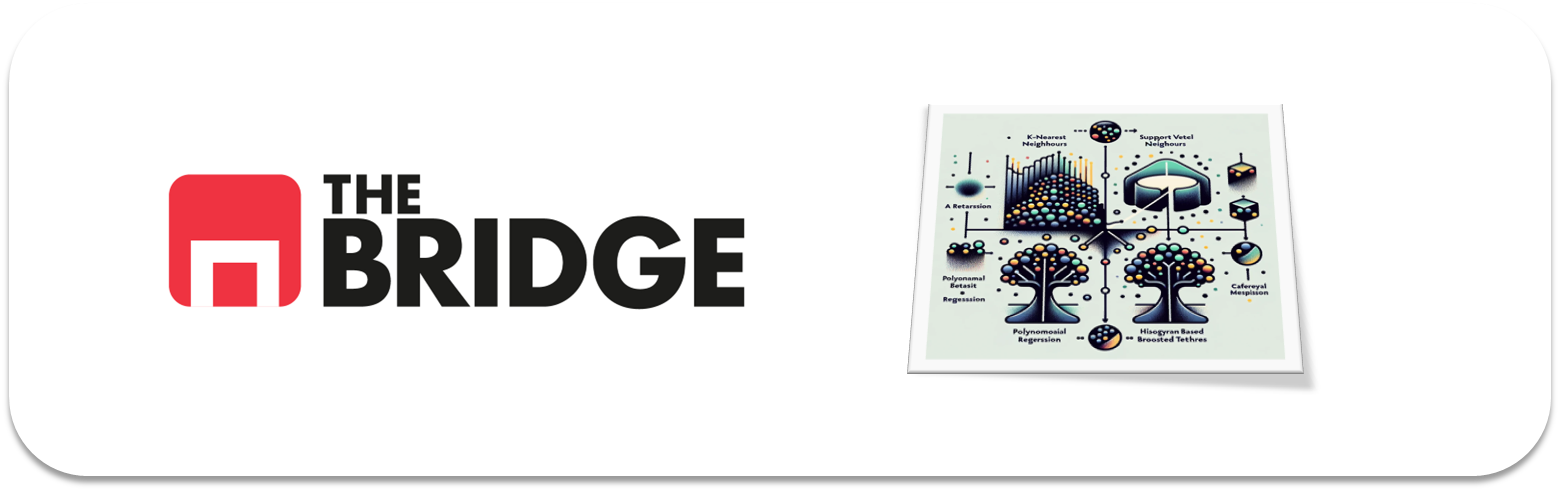

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [70]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [71]:
df=pd.read_csv("./wines_dataset.csv",sep="|")

In [72]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,7.7,0.39,0.34,10.00,0.056,35.0,178.0,0.99740,3.26,0.60,10.2,5,white
6493,8.2,0.73,0.21,1.70,0.074,5.0,13.0,0.99680,3.20,0.52,9.5,5,red
6494,7.4,0.31,0.48,14.20,0.042,62.0,204.0,0.99830,3.06,0.59,9.4,5,white
6495,8.3,0.65,0.10,2.90,0.089,17.0,40.0,0.99803,3.29,0.55,9.5,5,red


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

In [74]:
df.quality.value_counts(True)

quality
6    0.436509
5    0.329075
7    0.166077
4    0.033246
8    0.029706
3    0.004618
9    0.000770
Name: proportion, dtype: float64

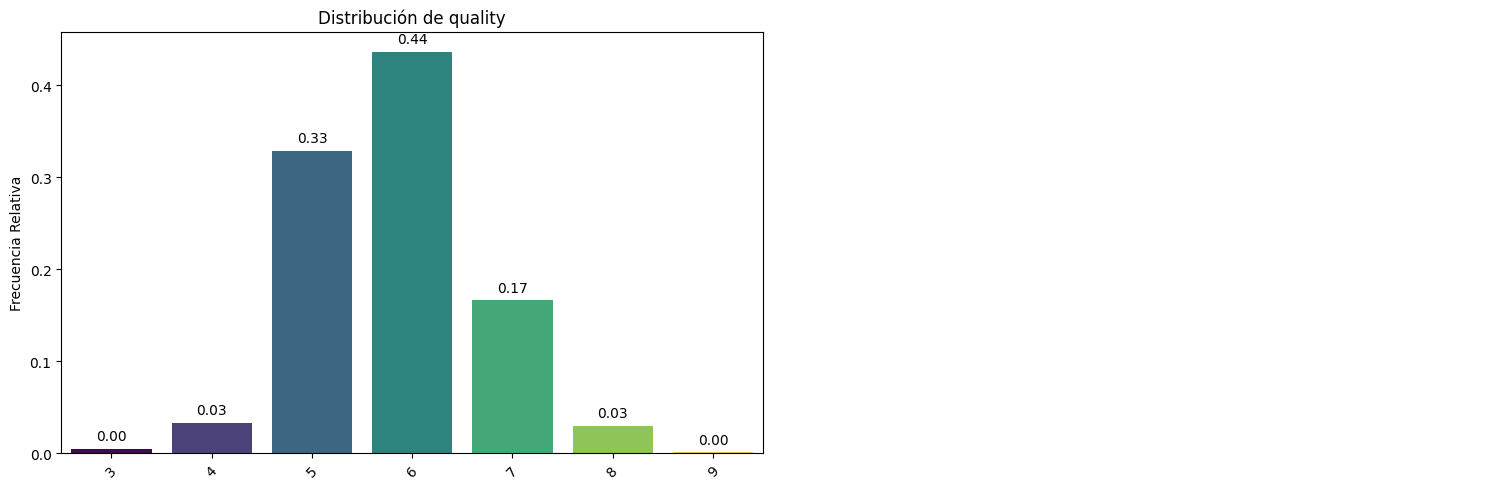

In [75]:
bt.pinta_distribucion_categoricas(df,["quality"],True,True)

In [76]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

In [77]:
bt.cardinalidad(train_set,5,10)

,Columna,Cardinalidad,% Cardinalidad,Valoración
0,fixed acidity,100,1.924187,Numérica Discreta
1,volatile acidity,177,3.405811,Numérica Discreta
2,citric acid,87,1.674043,Numérica Discreta
3,residual sugar,308,5.926496,Numérica Discreta
4,chlorides,194,3.732923,Numérica Discreta
5,free sulfur dioxide,132,2.539927,Numérica Discreta
6,total sulfur dioxide,274,5.272272,Numérica Discreta
7,density,951,18.299019,Numérica Continua
8,pH,106,2.039638,Numérica Discreta
9,sulphates,106,2.039638,Numérica Discreta


In [78]:
def classify_quality(quality):
    if quality in [3, 4, 5]:
        return 'low'
    elif quality == 6:
        return 'medium'
    elif quality in [7, 8, 9]:
        return 'high'

train_set['quality_class'] = train_set['quality'].apply(classify_quality)

train_set.drop("quality",axis=1,inplace=True)

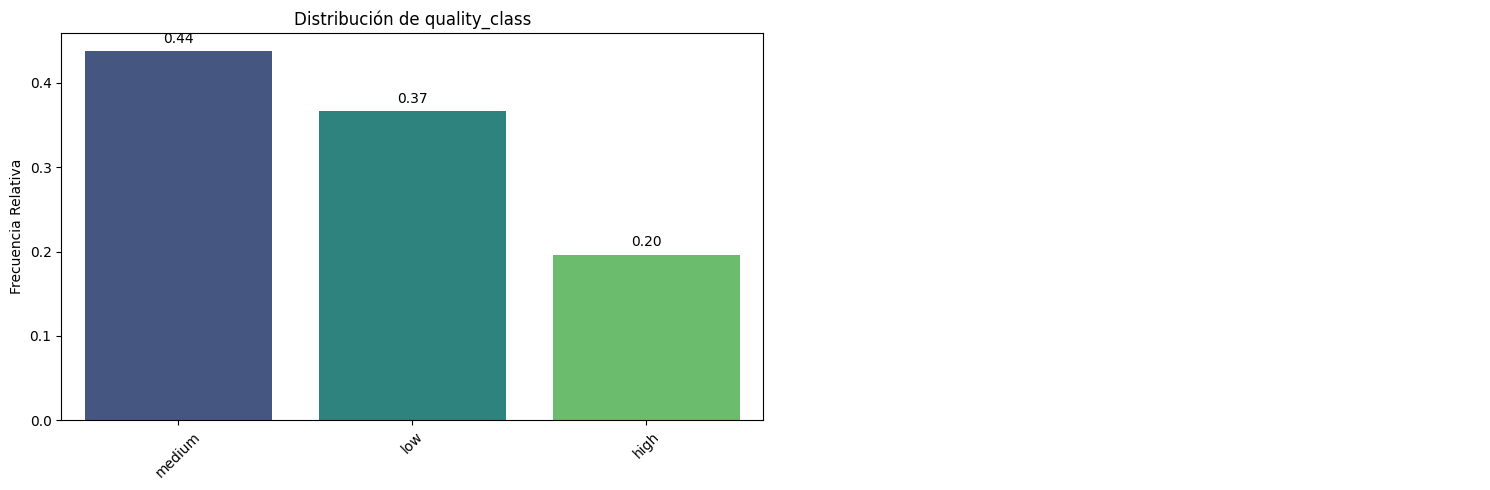

In [79]:
bt.pinta_distribucion_categoricas(train_set,["quality_class"],True,True)

In [80]:
target_log="quality_class"

In [81]:
#sns.pairplot(train_set, hue = target_log);

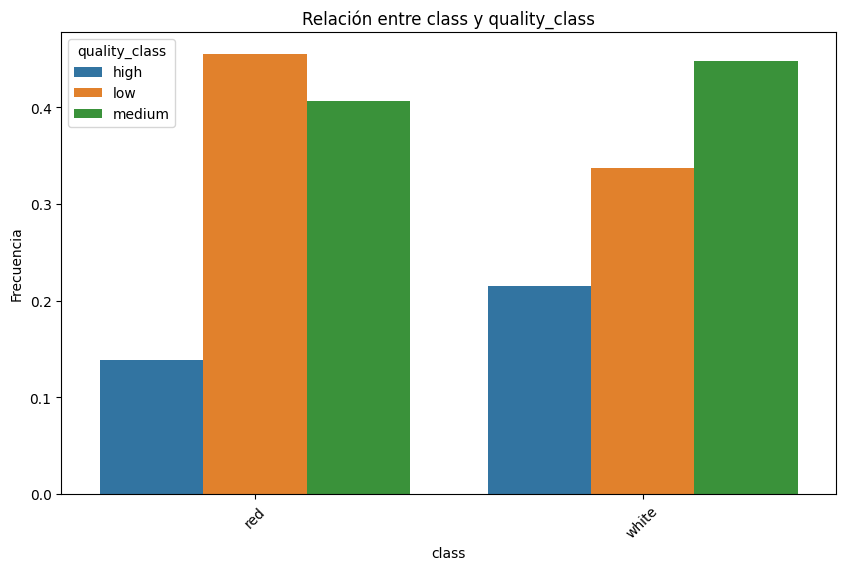

In [82]:
bt.plot_categorical_relationship_fin(train_set,"class",target_log,True)

In [83]:
variables_num=["volatile acidity","free sulfur dioxide","density","sulphates","alcohol"]
variables_cat="class"

<Axes: >

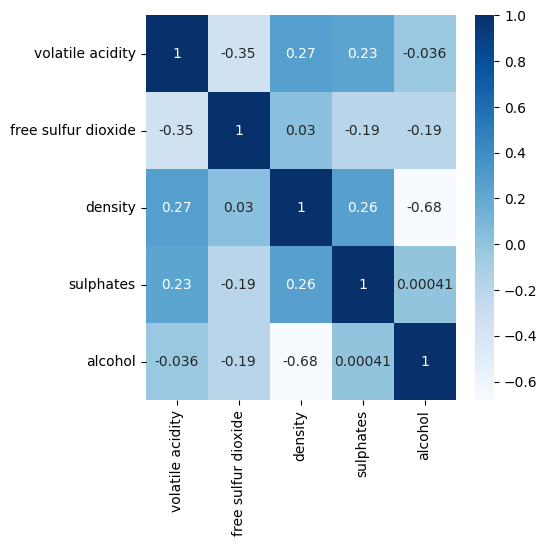

In [84]:
corr = train_set[variables_num].corr(numeric_only= True)
plt.figure(figsize = (5,5))
sns.heatmap(corr, annot= True, cmap = "Blues")

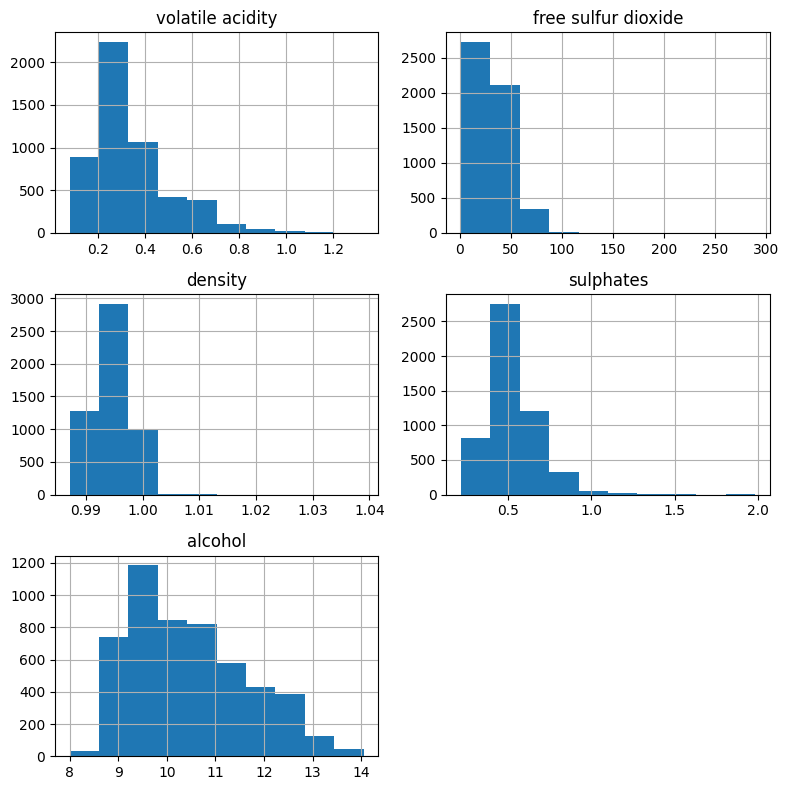

In [85]:
train_set[variables_num].hist(figsize = (8,8))
plt.tight_layout()

In [86]:
train_set["free sulfur dioxide"]=np.log(train_set["free sulfur dioxide"])

<Axes: >

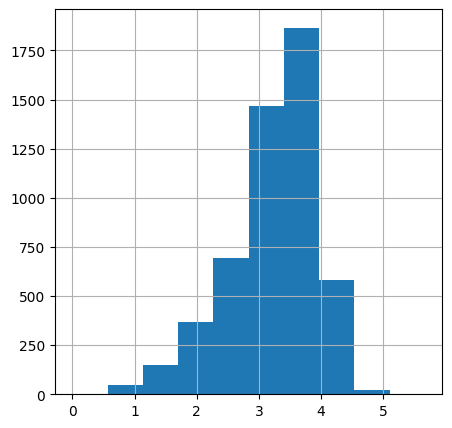

In [87]:
train_set["free sulfur dioxide"].hist(figsize = (5,5))

In [88]:
scaler = StandardScaler()
train_set[variables_num] = scaler.fit_transform(train_set[variables_num])

In [89]:
train_set = pd.get_dummies(train_set, columns=["class"])

In [90]:
variables_num

['volatile acidity', 'free sulfur dioxide', 'density', 'sulphates', 'alcohol']

In [91]:
train_set.drop(columns=["fixed acidity","citric acid","residual sugar","chlorides","total sulfur dioxide","pH"],inplace=True)

In [92]:
train_set

,volatile acidity,free sulfur dioxide,density,sulphates,alcohol,quality_class,class_red,class_white
1916,-0.979287,0.602369,0.426887,2.696948,0.678033,low,True,False
947,-0.979287,0.811171,1.622065,0.939171,-1.248291,medium,False,True
877,1.046217,-1.299026,-0.901088,-1.629887,0.259267,medium,False,True
2927,-0.549635,0.564386,0.058374,-0.210144,-0.913278,medium,False,True
6063,0.248291,-2.026577,0.440167,0.330710,1.180553,high,True,False
...,...,...,...,...,...,...,...,...
3772,-0.611014,1.252914,0.626083,0.263103,-0.997031,low,False,True
5191,-0.733772,0.006014,1.276791,-0.548178,-0.913278,low,False,True
5226,-0.856530,0.265688,-0.004705,0.195496,0.426774,high,False,True
5390,0.432428,0.061875,-1.933589,-1.224246,2.101838,high,False,True


In [93]:
#TEST
test_set.drop(columns=["fixed acidity","citric acid","residual sugar","chlorides","total sulfur dioxide","pH"],inplace=True)

In [94]:
test_set['quality_class'] = test_set['quality'].apply(classify_quality)
test_set.drop("quality",axis=1,inplace=True)

In [95]:
test_set["free sulfur dioxide"]=np.log(test_set["free sulfur dioxide"])

In [96]:
test_set[variables_num] = scaler.transform(test_set[variables_num])

In [97]:
test_set = pd.get_dummies(test_set, columns=["class"])

In [98]:
train_set

,volatile acidity,free sulfur dioxide,density,sulphates,alcohol,quality_class,class_red,class_white
1916,-0.979287,0.602369,0.426887,2.696948,0.678033,low,True,False
947,-0.979287,0.811171,1.622065,0.939171,-1.248291,medium,False,True
877,1.046217,-1.299026,-0.901088,-1.629887,0.259267,medium,False,True
2927,-0.549635,0.564386,0.058374,-0.210144,-0.913278,medium,False,True
6063,0.248291,-2.026577,0.440167,0.330710,1.180553,high,True,False
...,...,...,...,...,...,...,...,...
3772,-0.611014,1.252914,0.626083,0.263103,-0.997031,low,False,True
5191,-0.733772,0.006014,1.276791,-0.548178,-0.913278,low,False,True
5226,-0.856530,0.265688,-0.004705,0.195496,0.426774,high,False,True
5390,0.432428,0.061875,-1.933589,-1.224246,2.101838,high,False,True


In [99]:
y_train=train_set[target_log]
y_test=test_set[target_log]


In [101]:
X_train=train_set.drop(columns="quality_class")
X_test=test_set.drop(columns="quality_class")

In [105]:
from sklearn.neighbors import KNeighborsClassifier
rf_clf = RandomForestClassifier(max_depth= 6, random_state= 42)
lgb_clf = LGBMClassifier(max_depth= 6, random_sate = 42, verbose = -100)
knn = KNeighborsClassifier(5)

In [106]:
#KNN
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [107]:
print(classification_report(y_train, knn.predict(X_train)))

              precision    recall  f1-score   support

        high       0.65      0.68      0.66      1020
         low       0.75      0.77      0.76      1903
      medium       0.72      0.69      0.71      2274

    accuracy                           0.72      5197
   macro avg       0.71      0.71      0.71      5197
weighted avg       0.72      0.72      0.72      5197



In [108]:
recall_medio = np.mean(cross_val_score(knn, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
print(recall_medio)

0.5687519905514149


In [109]:
#ARBOLES
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [110]:
print(classification_report(y_train, rf_clf.predict(X_train)))

              precision    recall  f1-score   support

        high       0.76      0.37      0.50      1020
         low       0.70      0.71      0.70      1903
      medium       0.59      0.72      0.65      2274

    accuracy                           0.65      5197
   macro avg       0.68      0.60      0.62      5197
weighted avg       0.66      0.65      0.64      5197



In [111]:
recall_medio = np.mean(cross_val_score(rf_clf, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
print(recall_medio)

0.5394662075203792


In [112]:
#LGB
lgb_clf.fit(X_train, y_train)

LGBMClassifier(max_depth=6, random_sate=42, verbose=-100)

In [113]:
print(classification_report(y_train, lgb_clf.predict(X_train)))

              precision    recall  f1-score   support

        high       0.87      0.68      0.77      1020
         low       0.81      0.81      0.81      1903
      medium       0.75      0.81      0.78      2274

    accuracy                           0.79      5197
   macro avg       0.81      0.77      0.79      5197
weighted avg       0.79      0.79      0.79      5197



In [114]:
recall_medio = np.mean(cross_val_score(lgb_clf, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
print(recall_medio)

0.6014300538636832


In [115]:
#TUNEO
from sklearn.model_selection import RandomizedSearchCV


param_grid= {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = RandomizedSearchCV(lgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "recall_macro")

lgb_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(max_depth=6, random_sate=42,
                                            verbose=-100),
                   n_iter=20,
                   param_distributions={'bagging_fraction': [0.3, 0.6, 1],
                                        'feature_fraction': [0.5, 1],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4],
                                        'max_bins': [125, 250],
                                        'max_depth': [3, 6, 12],
                                        'n_estimators': [100, 250, 500, 750]},
                   scoring='recall_macro')

In [116]:
best = lgb_grid.best_estimator_

In [117]:
print(classification_report(y_test, best.predict(X_test)))

              precision    recall  f1-score   support

        high       0.66      0.63      0.65       257
         low       0.74      0.73      0.73       481
      medium       0.64      0.66      0.65       562

    accuracy                           0.68      1300
   macro avg       0.68      0.67      0.68      1300
weighted avg       0.68      0.68      0.68      1300



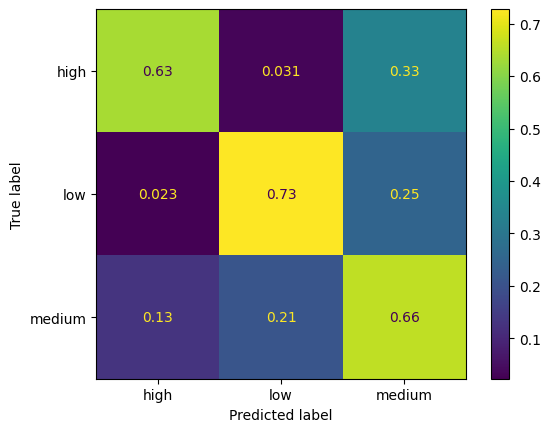

In [119]:
#INFORME DE ERRORES
ConfusionMatrixDisplay.from_predictions(y_test, best.predict(X_test), normalize= "true");

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

In [180]:
df=pd.read_csv("./wines_dataset.csv",sep="|")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,7.7,0.39,0.34,10.00,0.056,35.0,178.0,0.99740,3.26,0.60,10.2,5,white
6493,8.2,0.73,0.21,1.70,0.074,5.0,13.0,0.99680,3.20,0.52,9.5,5,red
6494,7.4,0.31,0.48,14.20,0.042,62.0,204.0,0.99830,3.06,0.59,9.4,5,white
6495,8.3,0.65,0.10,2.90,0.089,17.0,40.0,0.99803,3.29,0.55,9.5,5,red


In [124]:
target_num="alcohol"

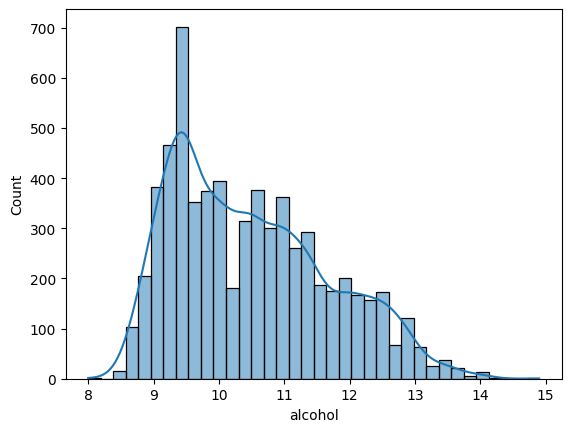

In [122]:
sns.histplot(x = "alcohol", data = df, kde = True);

In [183]:

y = df["quality"]  # columna objetivo

# Divide los datos de manera estratificada
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=y)

In [185]:
train_set.quality.value_counts(True)

quality
6    0.436598
5    0.329036
7    0.166057
4    0.033288
8    0.029632
3    0.004618
9    0.000770
Name: proportion, dtype: float64

In [186]:
test_set.quality.value_counts(True)

quality
6    0.436154
5    0.329231
7    0.166154
4    0.033077
8    0.030000
3    0.004615
9    0.000769
Name: proportion, dtype: float64

In [187]:
corr = train_set.corr(numeric_only= True)
np.abs(corr[target_num]).sort_values(ascending = False)

alcohol                 1.000000
density                 0.683073
quality                 0.439689
residual sugar          0.361373
total sulfur dioxide    0.265385
chlorides               0.260342
free sulfur dioxide     0.175778
pH                      0.113848
fixed acidity           0.085195
volatile acidity        0.043211
sulphates               0.005453
citric acid             0.004981
Name: alcohol, dtype: float64

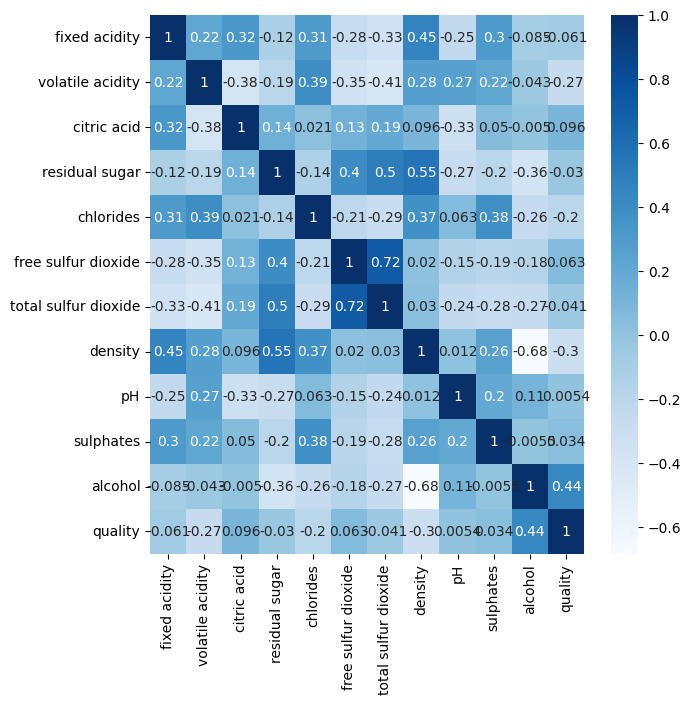

In [188]:
plt.figure(figsize = (7,7))
sns.heatmap(corr, annot= True, cmap = "Blues");

In [189]:
listado_var_num=bt.colinealidad(train_set,target_num,criterio_correlacion=0.10,categoricas=["class"])

Voy a comprobar la colinealidad con density
Comprobando con fixed acidity
No estaba ya en la lista original, no hago nada
Comprobando con volatile acidity
No estaba ya en la lista original, no hago nada
Comprobando con citric acid
No estaba ya en la lista original, no hago nada
Comprobando con residual sugar
Conmigo no tiene problema, dejo a residual sugar tranquila
Comprobando con chlorides
Conmigo no tiene problema, dejo a chlorides tranquila
Comprobando con free sulfur dioxide
Conmigo no tiene problema, dejo a free sulfur dioxide tranquila
Comprobando con total sulfur dioxide
Conmigo no tiene problema, dejo a total sulfur dioxide tranquila
Comprobando con density
soy yo misma, no me excluyo
Comprobando con pH
Conmigo no tiene problema, dejo a pH tranquila
Comprobando con sulphates
No estaba ya en la lista original, no hago nada
Comprobando con alcohol
No estaba ya en la lista original, no hago nada
Comprobando con quality
Conmigo no tiene problema, dejo a quality tranquila
Voy a com

In [190]:
listado_var_num

['density',
 'quality',
 'residual sugar',
 'total sulfur dioxide',
 'chlorides',
 'pH']

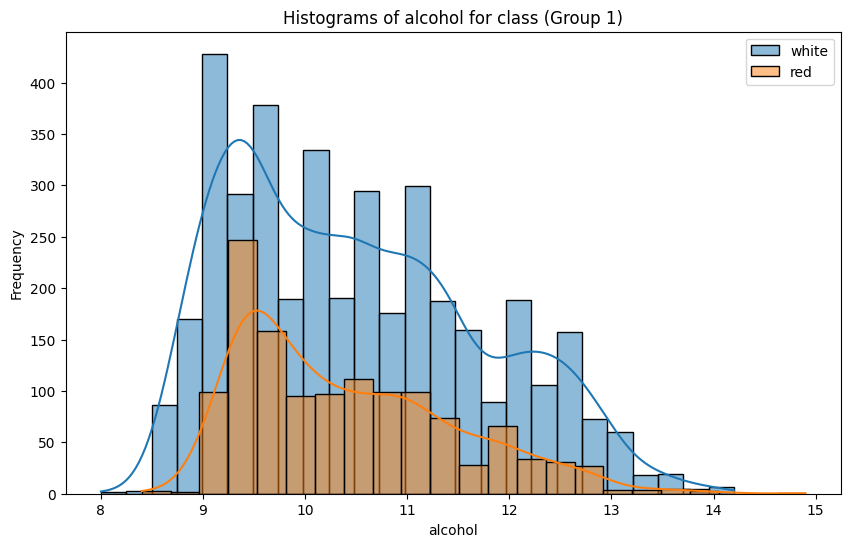

In [191]:
bt.plot_grouped_histograms(train_set,"class",target_num,10)

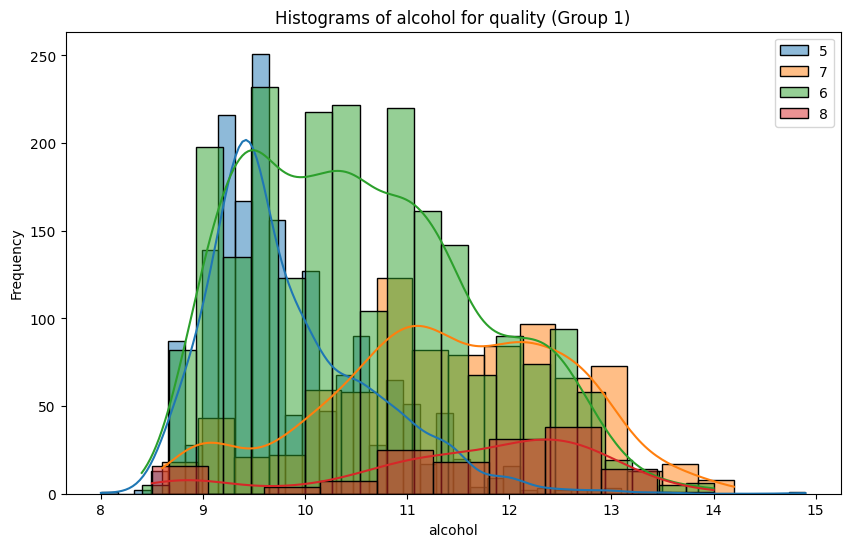

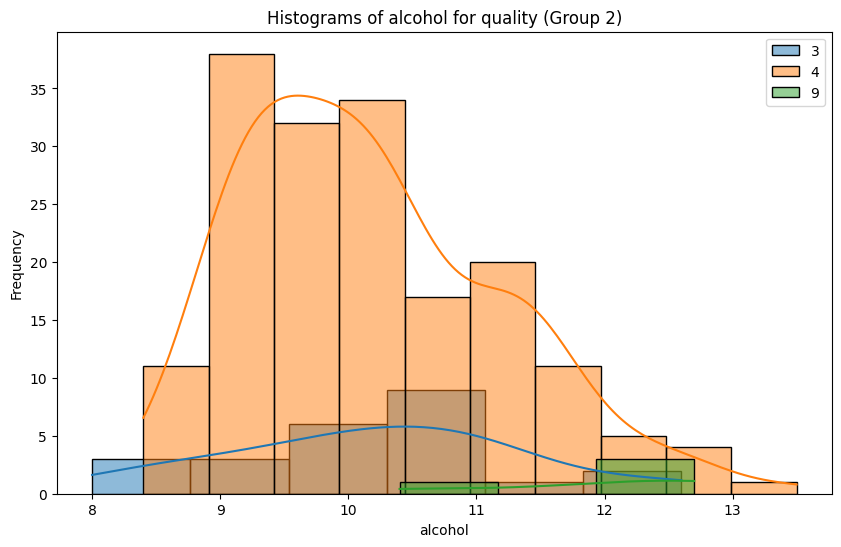

In [192]:
bt.plot_grouped_histograms(train_set,"quality",target_num,4)

In [193]:
listado_var_cat=["class","quality"]

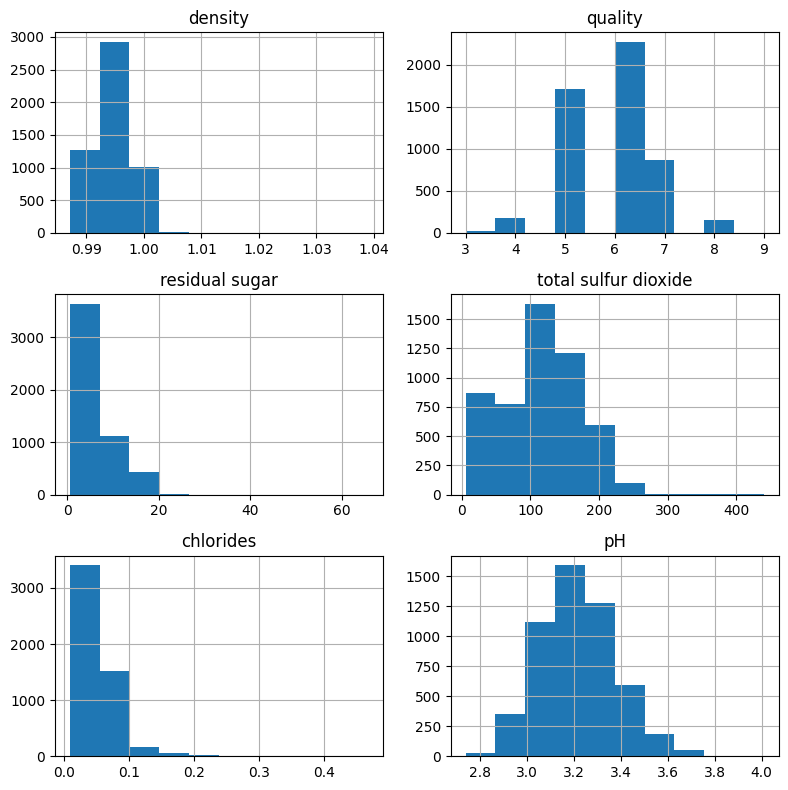

In [194]:
train_set[listado_var_num].hist(figsize = (8,8))
plt.tight_layout()

<Axes: >

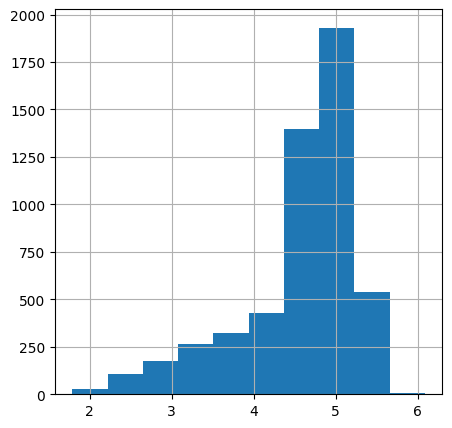

In [195]:
train_set["total sulfur dioxide"]=np.log(train_set["total sulfur dioxide"])
train_set["total sulfur dioxide"].hist(figsize = (5,5))

In [196]:
scaler = StandardScaler()
train_set[listado_var_num] = scaler.fit_transform(train_set[listado_var_num])

In [197]:
train_set = pd.get_dummies(train_set, columns=["class","quality"])

In [198]:
train_set.drop(columns=["fixed acidity","volatile acidity","citric acid","free sulfur dioxide"],inplace=True)

In [199]:
#TEST

test_set.drop(columns=["fixed acidity","volatile acidity","citric acid","free sulfur dioxide"],inplace=True)
test_set["total sulfur dioxide"]=np.log(test_set["total sulfur dioxide"])


In [200]:
test_set[listado_var_num] = scaler.transform(test_set[listado_var_num])

In [201]:
test_set = pd.get_dummies(test_set, columns=["class","quality"])

In [202]:
y_train=train_set[target_num]
y_test=test_set[target_num]

In [203]:
X_train=train_set.drop(columns="alcohol")
X_test=test_set.drop(columns="alcohol")

In [204]:
rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42) 
xgb_reg = XGBRegressor(max_depth = 10, random_state = 42)
lgb_reg = LGBMRegressor(max_depth = 10, random_state = 42, verbose = -100)


In [205]:
#RANDOM FOREST
rf_reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [206]:
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_absolute_percentage_error
pred_train = rf_reg.predict(X_train)

print("MAE:", median_absolute_error(y_train, pred_train))
print("RMSE:", mean_squared_error(y_train, pred_train, squared= False))
print("R^2:", rf_reg.score(X_train, y_train))

MAE: 0.19742375401487422
RMSE: 0.33516776212643384
R^2: 0.9199986089160628


In [207]:
resultado=cross_val_score(rf_reg, X_train, y_train, cv = 3, scoring = "neg_mean_squared_error")
print(resultado.mean())

-0.24136491347417818


In [208]:
#XGB
xgb_reg.fit(X_train,y_train)
pred_train = xgb_reg.predict(X_train)

In [209]:
print("MAE:", median_absolute_error(y_train, pred_train))
print("RMSE:", mean_squared_error(y_train, pred_train, squared= False))
print("R^2:", xgb_reg.score(X_train, y_train))

MAE: 0.003909683227538707
RMSE: 0.012428781561256918
R^2: 0.9998899905052984


In [210]:
resultado=cross_val_score(xgb_reg, X_train, y_train, cv = 3, scoring = "neg_mean_squared_error")
print(resultado.mean())

-0.2411606302139837


In [211]:
#LGB
lgb_reg.fit(X_train,y_train)
pred_train = lgb_reg.predict(X_train)

In [212]:
print("MAE:", median_absolute_error(y_train, pred_train))
print("RMSE:", mean_squared_error(y_train, pred_train, squared= False))
print("R^2:", lgb_reg.score(X_train, y_train))

MAE: 0.21946011241586127
RMSE: 0.36772692872593843
R^2: 0.9037005230220152


In [213]:
resultado=cross_val_score(lgb_reg, X_train, y_train, cv = 3, scoring = "neg_mean_squared_error")
print(resultado.mean())

-0.23808026410010963


In [214]:
#TUNEO


params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    #"min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

lgb_grid = RandomizedSearchCV(lgb_reg,
                       param_distributions= params_grid,
                       cv = 5,
                       scoring = "neg_mean_squared_error",
                       n_jobs = -1)

lgb_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(max_depth=10, random_state=42,
                                           verbose=-100),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 10],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_samples': [0.3, 0.6, 1],
                                        'n_estimators': [100, 200, 400]},
                   scoring='neg_mean_squared_error')

In [216]:
y_pred = lgb_grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test,y_pred))
print("RMSE:", mean_squared_error(y_test,y_pred))


MAE: 0.332714888012416
RMSE: 0.21236235980186272


Text(0, 0.5, 'Prediction')

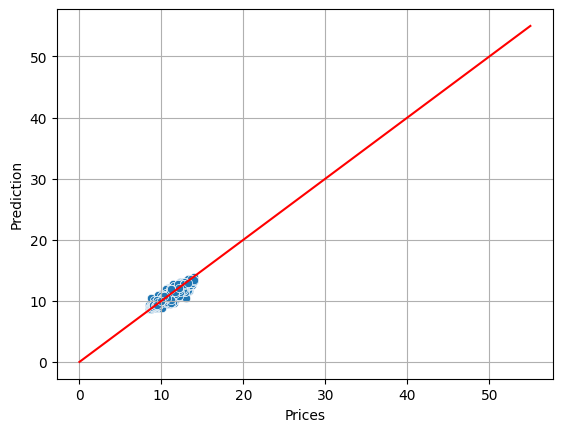

In [217]:
sns.scatterplot(x=y_test, y= y_pred)
plt.plot([0,55],[0,55],'red')
plt.grid()
plt.xlabel('Prices')
plt.ylabel('Prediction')